In [ ]:
# you have to delete the ""
!pip install tensorflow
!pip install segmentation_models

In [58]:
import tensorflow as tf
import segmentation_models as sm
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

BACKBONE = 'resnet34'
BATCH_SIZE = 8
EPOCHS = 20
LR = 0.0001
# n_classes = 4? - optional arg to model

preprocess_input = sm.get_preprocessing(BACKBONE)

SIZE_X = 256
SIZE_Y = 256

train_images = []
for img_path in os.listdir(f'./ACDC/database/train'):
    img = cv2.imread(f'./ACDC/database/train/{img_path}', cv2.IMREAD_COLOR)
    img = cv2.resize(img, (SIZE_Y, SIZE_X))
    #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    train_images.append(img)
train_images = np.array(train_images)

train_masks = []
for mask_path in os.listdir(f'./ACDC/database/trainannot'):
    mask = cv2.imread(f'./ACDC/database/trainannot/{mask_path}', 0)
    mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
    #mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
    train_masks.append(mask)
train_masks = np.array(train_masks)

X = train_images
Y = train_masks
Y = np.expand_dims(Y, axis=3)



In [75]:
activation = 'sigmoid' # 'softmax' - ezzel kéne, csak fekete a kép
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [76]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet', activation=activation)
# model.compile(optimizer=optim, loss=total_loss, metrics=metrics)
# model.compile(optimizer=optim, loss='binary_crossentropy', metrics=metrics) - ezzel valahogy működött, csak fekete a kép

# print(model.summary())

In [77]:
# from sklearn.model_selection import train_test_split
# x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# # preprocess input
# x_train = preprocess_input(x_train)
# x_val = preprocess_input(x_val)

# define model
# model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse'])

In [78]:
history=model.fit(x_train,
          y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=1,
          validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 29s 256ms/step - loss: -27.6792 - mse: 1391.6543 - val_loss: -18191.6387 - val_mse: 1293.5156
Epoch 2/20
16/16 [==============================] - 3s 161ms/step - loss: -70.9996 - mse: 1390.0618 - val_loss: -530290.0000 - val_mse: 1293.5137
Epoch 3/20
16/16 [==============================] - 3s 171ms/step - loss: -106.8174 - mse: 1390.0114 - val_loss: -140279.0469 - val_mse: 1293.5127
Epoch 4/20
16/16 [==============================] - 3s 172ms/step - loss: -150.2557 - mse: 1389.8057 - val_loss: -41479.6055 - val_mse: 1293.4734
Epoch 5/20
16/16 [==============================] - 3s 164ms/step - loss: -211.0696 - mse: 1389.6882 - val_loss: -28347.8848 - val_mse: 1293.3687
Epoch 6/20
16/16 [==============================] - 3s 165ms/step - loss: -259.7216 - mse: 1389.5183 - val_loss: -42145.1602 - val_mse: 1293.2009
Epoch 7/20
16/16 [==============================] - 3s 164ms/step - loss: -312.4700 - mse: 1389.4182 - val_loss: -17428.543

1/1 [==============================] - 2s 2s/step - loss: -10291.6797 - mse: 1293.1675


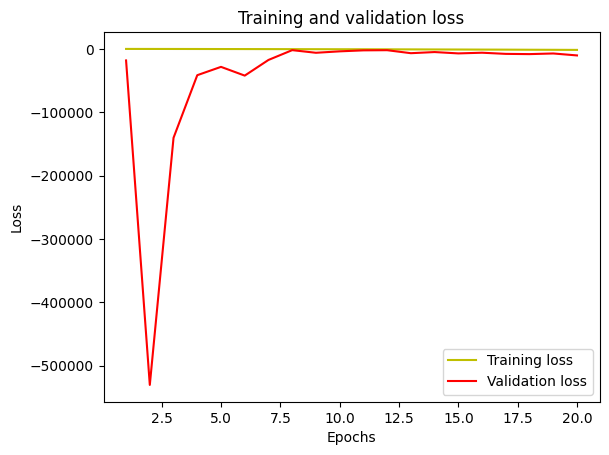

In [79]:
accuracy = model.evaluate(x_val, y_val)
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [13]:
model.save('base_model_test.h5')

1/1 [==============================] - 1s 792ms/step


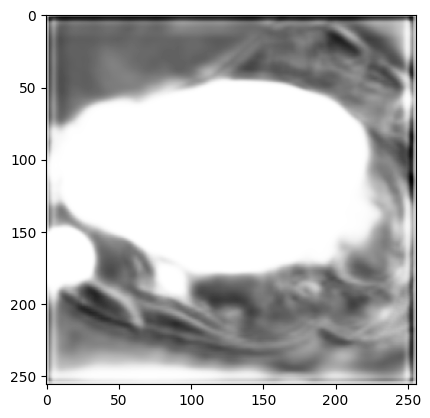

In [80]:

from tensorflow import keras
# model = keras.models.load_model('base_model_test.h5', compile=False)
#Test on a different image
test_img = cv2.imread('./ACDC/database/test/patient101_1.jpg', cv2.IMREAD_COLOR)
test_img = cv2.resize(test_img, (SIZE_Y, SIZE_X))
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
plt.subplot(1, 2, 1)
plt.imshow(test_img, cmap='gray')
test_img = np.expand_dims(test_img, axis=0)

prediction = model.predict(test_img)

#View and Save segmented image
prediction_image = prediction.reshape(mask.shape)
plt.subplot(1, 2, 2)
plt.imshow(prediction_image, cmap='gray')
plt.imsave('./test_segmented.jpg', prediction_image, cmap='gray')



In [ ]:
# evaluate: test dataaset, model.load_weights('best_model.h5') ,
# print("Loss: {:.5}".format(scores[0]))
# for metric, value in zip(metrics, scores[1:]):
#     print("mean {}: {:.5}".format(metric.__name__, value))